# Laptop Price Prediction

This project aims to build a model to predict laptop prices using XGBRegressor.

## Project Setup

Import libraries

In [1]:
import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd
import regex as re
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler, OrdinalEncoder
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from xgboost import XGBRegressor

## Data Preparation

Load the dataset

In [2]:
df = pd.read_csv("datasets/laptop_price.csv", encoding='latin-1')
df.head()

,laptop_ID,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_euros
0,1,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37kg,1339.69
1,2,Apple,Macbook Air,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,898.94
2,3,HP,250 G6,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,No OS,1.86kg,575.00
3,4,Apple,MacBook Pro,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16GB,512GB SSD,AMD Radeon Pro 455,macOS,1.83kg,2537.45
4,5,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8GB,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37kg,1803.60


Drop laptop ID

In [3]:
df = df.drop("laptop_ID", axis=1)
df.head()

,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_euros
0,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37kg,1339.69
1,Apple,Macbook Air,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,898.94
2,HP,250 G6,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,No OS,1.86kg,575.00
3,Apple,MacBook Pro,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16GB,512GB SSD,AMD Radeon Pro 455,macOS,1.83kg,2537.45
4,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8GB,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37kg,1803.60


Check duplicate rows

In [4]:
len(df[df.duplicated()])

28

In [5]:
df = df.drop_duplicates()

Remove GB from Ram

In [6]:
df['Ram'] = df['Ram'].str.replace("GB","")
df['Ram'] = df['Ram'].astype(int)
df.head()

,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_euros
0,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37kg,1339.69
1,Apple,Macbook Air,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,898.94
2,HP,250 G6,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8,256GB SSD,Intel HD Graphics 620,No OS,1.86kg,575.00
3,Apple,MacBook Pro,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16,512GB SSD,AMD Radeon Pro 455,macOS,1.83kg,2537.45
4,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37kg,1803.60


Remove Kg from Weight

In [7]:
df['Weight'] = df['Weight'].str.replace("kg","")
df['Weight'] = df['Weight'].astype(float)
df.head()

,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_euros
0,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37,1339.69
1,Apple,Macbook Air,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34,898.94
2,HP,250 G6,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8,256GB SSD,Intel HD Graphics 620,No OS,1.86,575.00
3,Apple,MacBook Pro,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16,512GB SSD,AMD Radeon Pro 455,macOS,1.83,2537.45
4,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37,1803.60


In [8]:
df["resolution"] = df['ScreenResolution'].str.extract(r'(\d+x\d+)')
df['touchscreen'] = df['ScreenResolution'].str.extract(r'(touchscreen)', re.IGNORECASE).fillna('No')
df = df.drop("ScreenResolution", axis=1)

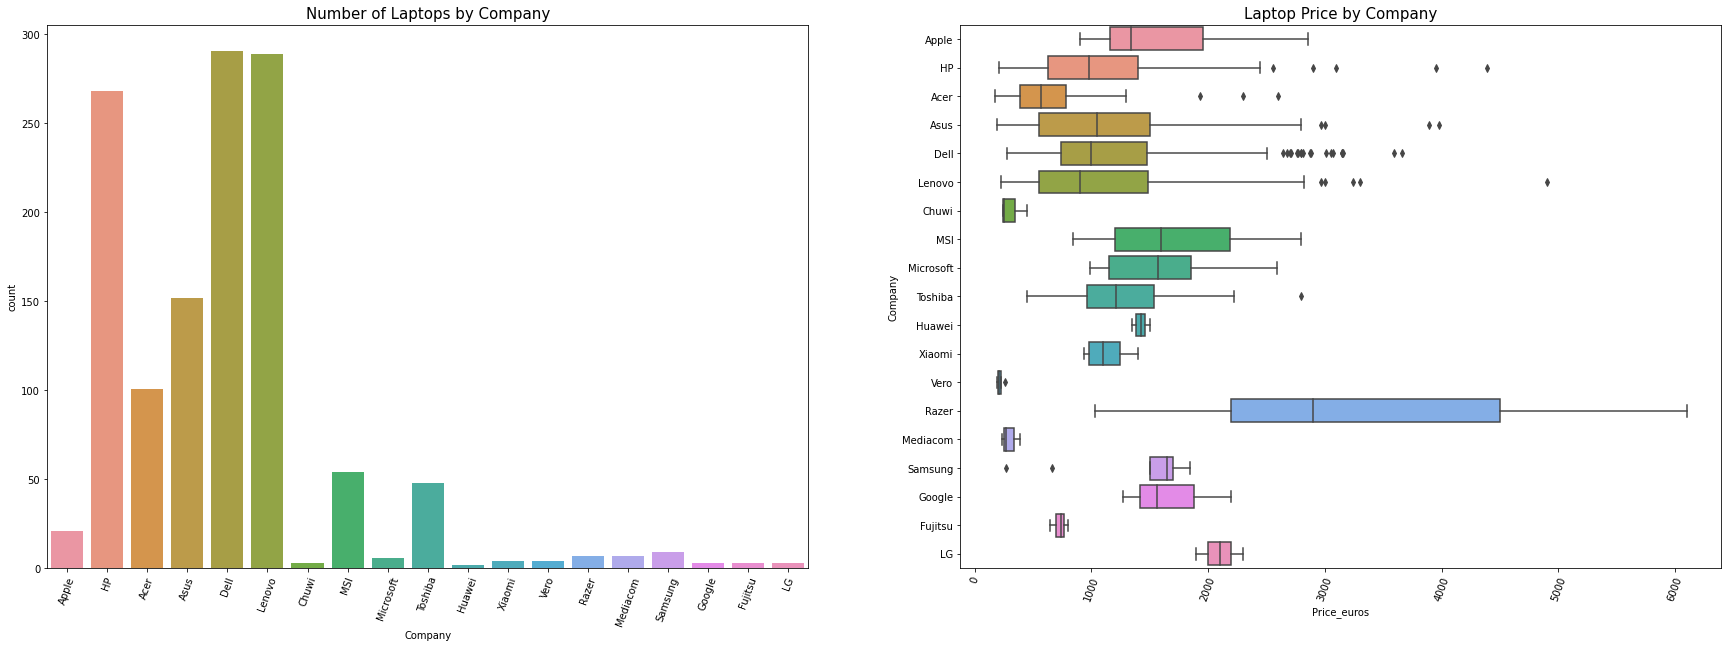

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(30, 10))

for ax in axes:
    plt.sca(ax)
    plt.xticks(rotation=70)
    
sns.countplot(x="Company", data=df, ax=axes[0])
sns.boxplot(x="Price_euros", y="Company", data=df, ax=axes[1])
axes[0].set_title("Number of Laptops by Company",fontsize=15)
axes[1].set_title("Laptop Price by Company",fontsize=15)
plt.show()

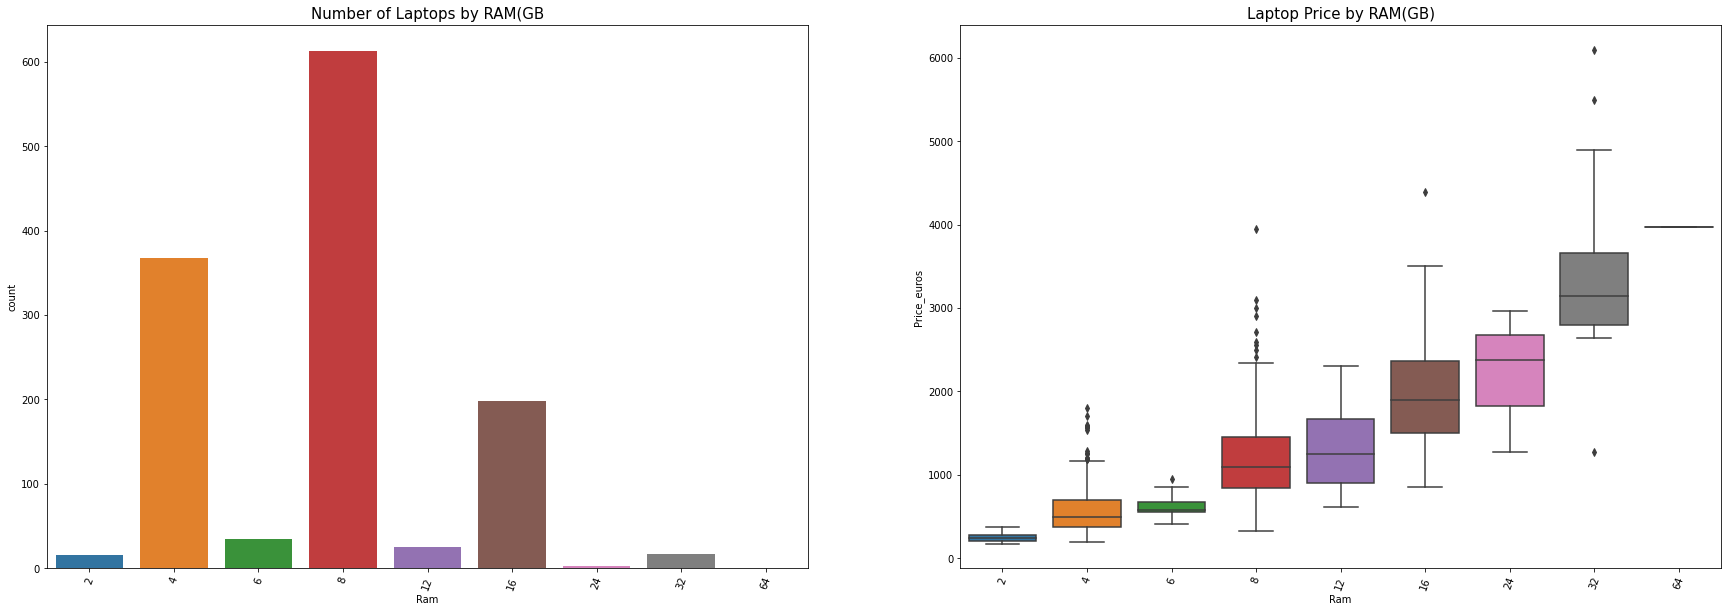

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(30, 10))

for ax in axes:
    plt.sca(ax)
    plt.xticks(rotation=70)
    
sns.countplot(x="Ram", data=df, ax=axes[0])
sns.boxplot(x="Ram", y="Price_euros", data=df, ax=axes[1])
axes[0].set_title("Number of Laptops by RAM(GB",fontsize=15)
axes[1].set_title("Laptop Price by RAM(GB)",fontsize=15)
plt.show()

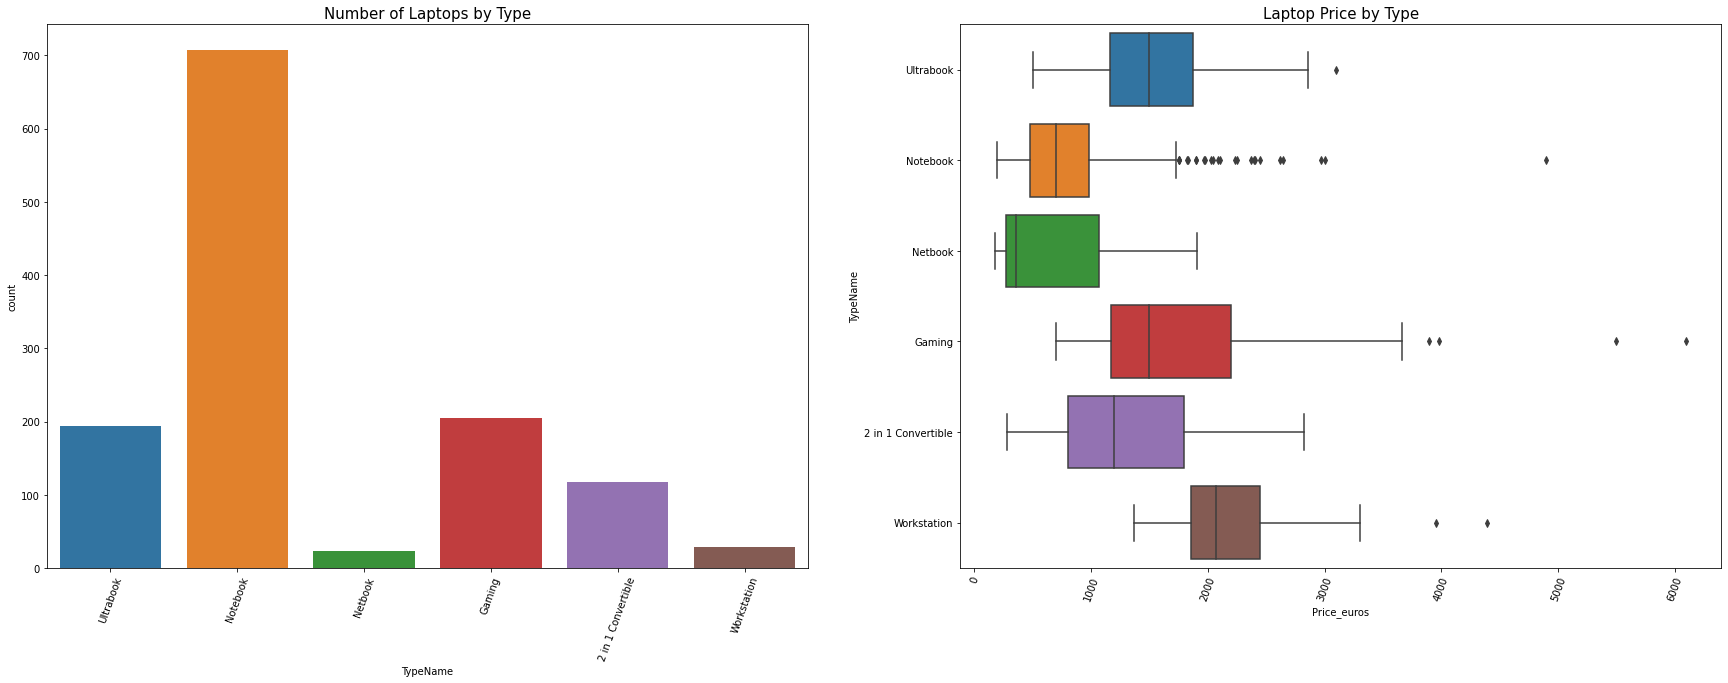

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(30, 10))

for ax in axes:
    plt.sca(ax)
    plt.xticks(rotation=70)
    
sns.countplot(x="TypeName", data=df, ax=axes[0])
sns.boxplot(x="Price_euros", y="TypeName", data=df, ax=axes[1])
axes[0].set_title("Number of Laptops by Type",fontsize=15)
axes[1].set_title("Laptop Price by Type",fontsize=15)
plt.show()

In [12]:
columns = ["Company", "Product", "TypeName", "Cpu", "Memory", "Gpu", "OpSys", "resolution", "touchscreen"]

encoder = OrdinalEncoder()

df[columns] = encoder.fit_transform(df[columns])

In [13]:
X = df.drop("Price_euros", axis=1)
y = pd.DataFrame(df["Price_euros"]).copy()

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.20, random_state=42)

In [15]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

In [16]:
model = XGBRegressor()

In [17]:
params = { 'max_depth': [2, 4, 6],
           'n_estimators': [100, 500, 1000],
           'colsample_bytree': [0.1, 0.2, 0.6, 0.8],
           'min_child_weight': [3, 5, 7],
           'gamma': [0, 0.3, 0.5, 0.7, 0.9],
           'subsample': [0.4, 0.6, 0.8]}

grid_search = GridSearchCV(model, param_grid=params, scoring="r2", n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

GridSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    gamma=None, gpu_id=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bin=None,
                                    max_cat_to_o...
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=None,
                                    reg_alpha=None, reg_lambda=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.1, 0.2, 0.6, 0.8],
                         'gamma': [0, 0.3, 0.5, 0.7, 0.9],
                         'max_depth': [2, 4, 6], 'min_child_weight': [3, 5, 7],
                         'n_estimators': [100, 500, 1000],
                         'subsample': [0.4, 0.6, 0.8]},
             scoring='r2')

In [18]:
regressor = grid_search.best_estimator_

In [19]:
y_train_pred = regressor.predict(X_train_scaled)

In [20]:
r2_train = r2_score(y_train, y_train_pred)
rmse_train = mean_squared_error(y_train, y_train_pred, squared=False)
print(f"Train R-Squared: {r2_train:.3f}")
print(f"Train RMSE: {rmse_train:.3f}")

Train R-Squared: 1.000
Train RMSE: 7.493


In [21]:
cv_score = cross_val_score(regressor, X_train_scaled, y_train, cv=10)
print(f"Cross Validation R-Squared: {cv_score.mean():.3f}" )

Cross Validation R-Squared: 0.748


In [22]:
y_test_pred = regressor.predict(X_test_scaled)

In [23]:
r2_test = r2_score(y_test, y_test_pred)
rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)
print(f"Test R-Squared: {r2_test:.3f}")
print(f"Test RMSE: {rmse_test:.3f}")

Test R-Squared: 0.754
Test RMSE: 351.761


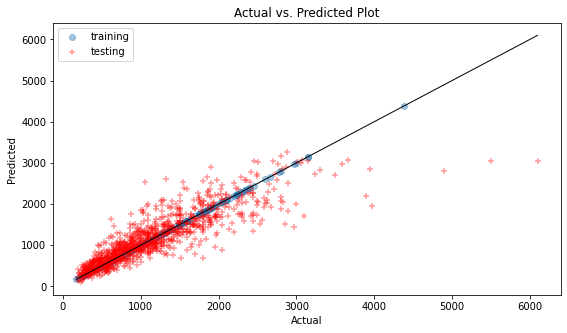

In [24]:
fig=plt.figure(figsize=(20,5))

ax1=plt.subplot(1,2,1)
ax1.scatter(y_train, y_train_pred, label="training", alpha=0.4)
ax1.scatter(y_test, y_test_pred, marker="+", c="r", label="testing", alpha=0.4)
ax1.plot([y.min(), y.max()], [y.min(), y.max()], "k", lw=1)
ax1.set_title("Actual vs. Predicted Plot")
ax1.set_xlabel("Actual")
ax1.set_ylabel("Predicted")
ax1.legend()